In [1]:
modelPath = "Clickbait"
checkpoint = "microsoft/Multilingual-MiniLM-L12-H384"   # "cmarkea/distilcamembert-base-sentiment"
                                              # "cmarkea/distilcamembert-base"
                                              # "camembert-base"
                                              # "microsoft/Multilingual-MiniLM-L12-H384"
                                              # "nlptown/bert-base-multilingual-uncased-sentiment"
                                              # "distilbert-base-uncased-finetuned-sst-2-english"
                                              # "bert-base-uncased"
problem_type =  "single_label_classification" # Valeurs possibles : "regression", "single_label_classification", "multi_label_classification"
num_labels = 2                                # 5
dataCuratedPath = "Data/Curated"              # Données pour tous les sites du 1er janvier 2021 au 30 avril 2021
                                              # Données juste pour le site "Actualités, trucs et astuces" entre le 1er mai et le 31 juillet 2021.
                                              # Les colonnes sont les suivantes, séparées par des ";" :
                                              #    Page name;Title;Publish time;People Reached;Link Clicks
LCfraction = 'truthMean'                      # 'LCFraction'
inputColumn = 'targetTitle'
removeColumns = ['postText', 'targetTitle', 'postTimestamp', 'targetKeywords', 'targetDescription', 'id', 'truthMean'] # Il faut enlever les colonnes de type texte
splitFactor = 0.1                             # Proportion de données réservées pour les tests
push_to_hub = False
learning_rate = 5e-5
weight_decay=0.01

In [2]:
import torch
import numpy as np

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(
   checkpoint,
   problem_type=problem_type, # on pourra enlever ce paramètre si ca marche plus
   num_labels = num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/Multilingual-MiniLM-L12-H384 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
print(tokenizer("Bonjour, comment ça va ?"))
print(tokenizer.tokenize("Bonjour, comment ça va ?"))
print(tokenizer.encode("Bonjour, comment ça va ?"))
print(tokenizer.convert_tokens_to_ids(['▁Bonjour', ',', '▁comment', '▁ça', '▁va', '▁?']))
print(tokenizer.convert_ids_to_tokens([1285, 7, 404, 136, 198, 106]))
print(tokenizer.decode([5, 1285, 7, 404, 136, 198, 106, 6]))

{'input_ids': [0, 84602, 4, 6868, 3244, 307, 705, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}
['▁Bonjour', ',', '▁comment', '▁ça', '▁va', '▁?']
[0, 84602, 4, 6868, 3244, 307, 705, 2]
[84602, 4, 6868, 3244, 307, 705]
['▁די', 's', '▁zu', '▁and', '▁es', '▁1']
. דיs zu and es 1 


In [5]:
import datasets as ds

In [6]:
curated = ds.load_from_disk(dataCuratedPath)

In [7]:
curated.to_pandas()

,postText,id,targetTitle,postTimestamp,targetKeywords,targetDescription,truthMean
0,[UK’s response to modern slavery leaving victi...,858462320779026432,‘Inexcusable’ failures in UK’s response to mod...,Sat Apr 29 23:25:41 +0000 2017,"modern slavery, Department For Work And Pensio...",“Inexcusable” failures in the UK’s system for ...,1.000000
1,[this is good],858421020331560960,Donald Trump Appoints Pro-Life Advocate as Ass...,Sat Apr 29 20:41:34 +0000 2017,"Americans United for Life, Dr. Charmaine Yoest...",President Donald Trump has appointed pro-life ...,0.133333
2,"[The ""forgotten"" Trump roast: Relive his bruta...",858368123753435136,The ‘forgotten’ Trump roast: Relive his brutal...,Sat Apr 29 17:11:23 +0000 2017,"trump whcd, whcd, white house correspondents d...",President Trump won't be at this year's White ...,0.400000
3,[Meet the happiest #dog in the world!],858323428260139008,"Meet The Happiest Dog In The World, Maru The H...",Sat Apr 29 14:13:46 +0000 2017,"Maru, husky, dogs, pandas, furball, instagram","The article is about Maru, a husky dog who has...",0.266667
4,[Tokyo's subway is shut down amid fears over a...,858283602626347008,Tokyo's subway is shut down amid fears over an...,Sat Apr 29 11:35:31 +0000 2017,"Tokyo,subway,shut,fears,North,Korean,attack","The temporary suspension, which lasted ten min...",0.000000
...,...,...,...,...,...,...,...
19533,[Brazil soccer team and pilot's final intervie...,804250183642976256,"NBC News Video See Brazil Soccer Team, Pilot’s...",Thu Dec 01 09:06:00 +0000 2016,,NBC News,0.133333
19534,[😱😱😱😱😱😱😱😱😱😱😱😱😱😱],804156272086020096,Politico Scoop: Eric Trump Killed Two Deer,Thu Dec 01 02:52:50 +0000 2016,Politico Scoop: Eric Trump Killed Two Deer,Politico Scoop: Eric Trump Killed Two Deer,0.066667
19535,[Frenchs Forest high school may have to make w...,804149798651588608,Frenchs Forest high school may relocate to mak...,Thu Dec 01 02:27:07 +0000 2016,"frenchs forest, northern beaches, sydney, rede...",The Forest High School on Sydney's northern be...,0.333333
19536,[Oh Jeff… #bruh],804134698729385984,Los Angeles Rams Jeff Fisher May Think Danny W...,Thu Dec 01 01:27:06 +0000 2016,"Humor, Football, NFL, NFC West, Los Angeles Ra...","Los Angeles Rams news, rumors, scores, schedul...",0.733333


In [8]:
longueur= len(curated)

In [9]:
trie=sorted(curated[LCfraction])

In [10]:
import matplotlib.pyplot as plt

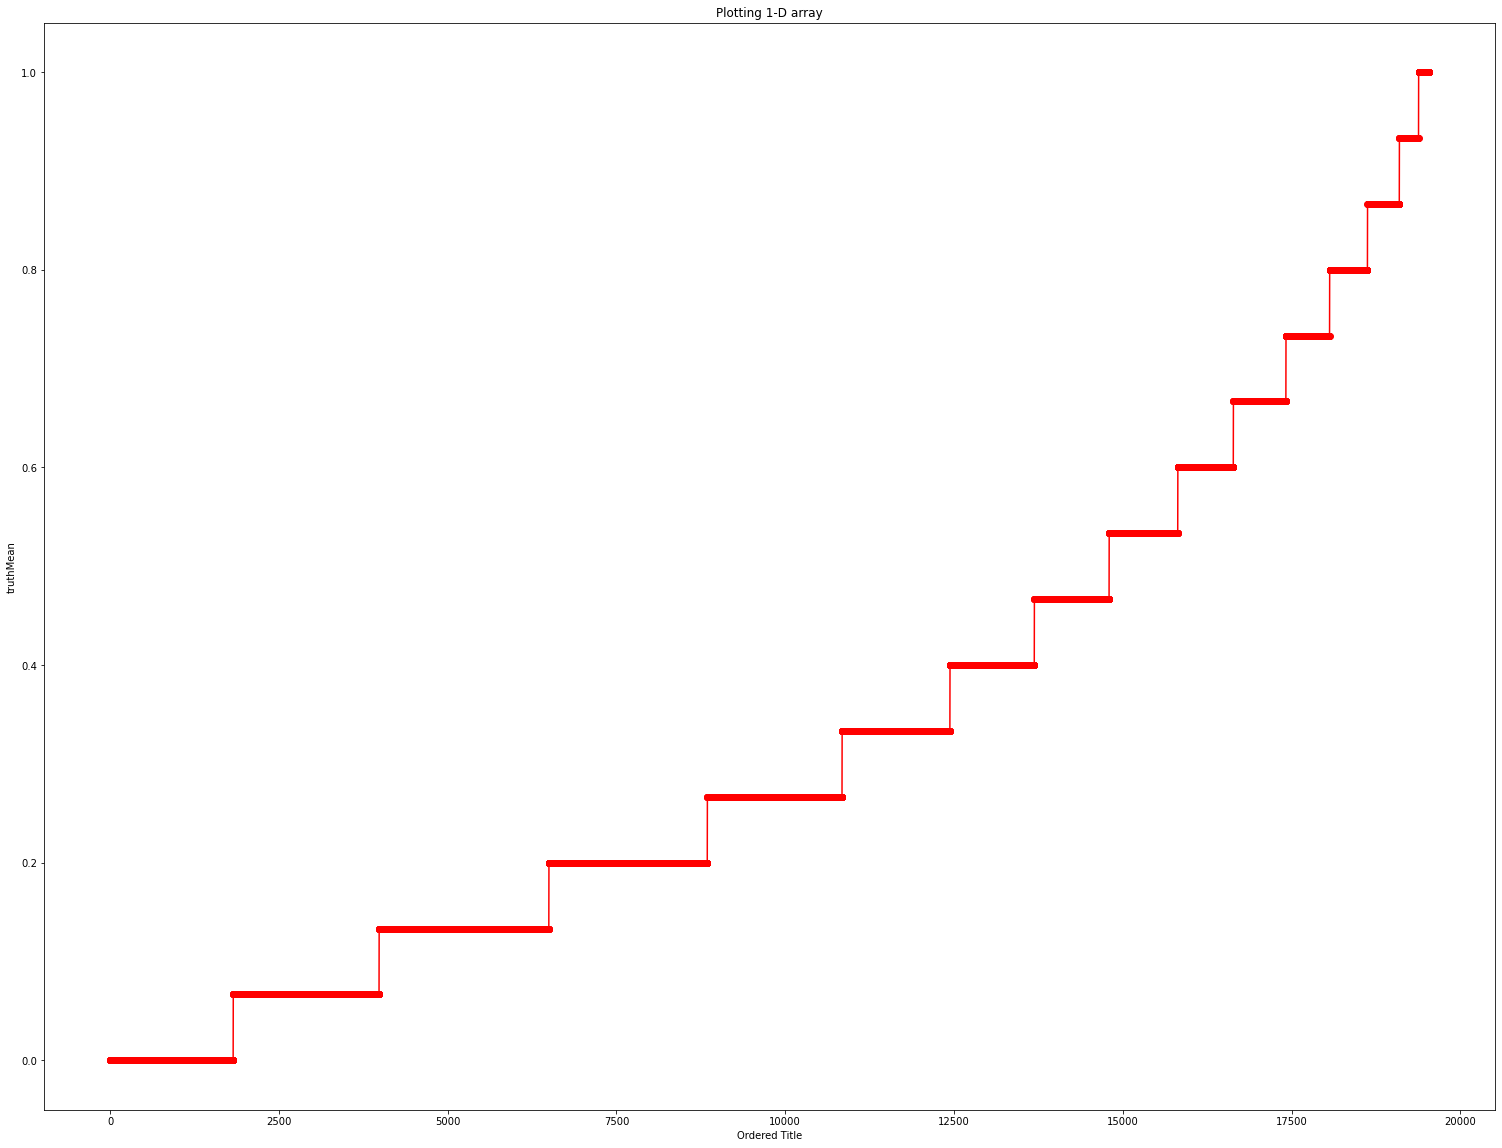

In [11]:
plt.figure(figsize=(26, 20))
plt.title("Plotting 1-D array")
plt.xlabel("Ordered Title")
plt.ylabel(LCfraction)
x = np.array(range(0, longueur))
y = np.array(trie)
plt.plot(x, y, color = "red", marker = "o", label = "Array elements")

In [12]:
ncf=[None] * (num_labels-1)
for i in range(num_labels-1):
    ncf[i] = trie[longueur * (i+1) // num_labels]
ncf

[0.26666666664]

In [13]:
def tokenize(sample):
    tokenized_sample = tokenizer(
            sample[inputColumn],   #  postText + ". Paru dans " + sample["Page name"], #+ ", le " + sample["Publish time"]
            #padding=True,
            #truncation=True,
            #max_length=30
            )
    fraction = sample[LCfraction]
    
    if num_labels == 1:
        tokenized_sample["labels"] = fraction
    else:
        tokenized_sample["labels"] = next((x for x, val in enumerate(ncf) if fraction < val), num_labels-1)
        
    # print( fraction, tokenized_sample["labels"], sample['postText'])
    
    return tokenized_sample

In [14]:
tokenized_curated = curated.map(tokenize) #, batched=True)

  0%|          | 0/19538 [00:00<?, ?ex/s]

In [15]:
tokenized_curated

Dataset({
    features: ['postText', 'id', 'targetTitle', 'postTimestamp', 'targetKeywords', 'targetDescription', 'truthMean', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 19538
})

In [16]:
print(tokenized_curated[0:2])

{'postText': [['UK’s response to modern slavery leaving victims destitute while abusers go free'], ['this is good']], 'id': [858462320779026432, 858421020331560960], 'targetTitle': ['‘Inexcusable’ failures in UK’s response to modern slavery leaving victims destitute while abusers go free, report warns', 'Donald Trump Appoints Pro-Life Advocate as Assistant Secretary of HHS for Public Affairs'], 'postTimestamp': ['Sat Apr 29 23:25:41 +0000 2017', 'Sat Apr 29 20:41:34 +0000 2017'], 'targetKeywords': ['modern slavery, Department For Work And Pensions, People Trafficking, Frank Field, Home News, UK, News', 'Americans United for Life, Dr. Charmaine Yoest, Planned Parenthood, pro-life, U.S. Department of Health and Human Services,Abortion, Big Government,Pro-Life'], 'targetDescription': ['“Inexcusable” failures in the UK’s system for dealing with modern slavery are\xa0leaving victims reduced to destitution while their abusers go free because they are not adequately supported to testify again

In [17]:
tokenized_curated2 = tokenized_curated.train_test_split(splitFactor) # 0.2

In [18]:
tokenized_curated2['train'].to_pandas()

,postText,id,targetTitle,postTimestamp,targetKeywords,targetDescription,truthMean,input_ids,attention_mask,labels
0,[.@IAmSteveHarvey says @POTUS is 'keeping his ...,855098282330255360,Steve Harvey says Trump is 'keeping his word',Thu Apr 20 16:38:12 +0000 2017,,Steve Harvey said President Donald Trump is a ...,0.333333,"[0, 41550, 194092, 17378, 5879, 83, 242, 50453...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1
1,[Pizza dipped in milk is a crime against pizza...,838167206009659392,Pizza dipped in milk is the most disrespectful...,Sat Mar 04 23:20:08 +0000 2017,"twitter, pizza, food, watercooler","What, are you really going to drink cheesy tom...",0.066667,"[0, 78011, 45, 48398, 23, 124111, 83, 70, 2684...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0
2,[Dutch election explained in tulips],841081528314658816,Dutch election explained in tulips,Mon Mar 13 00:20:37 +0000 2017,,Politics is a complicated affair in the Nether...,0.666667,"[0, 174705, 81843, 189050, 23, 370, 95680, 2]","[1, 1, 1, 1, 1, 1, 1, 1]",1
3,[Think your fate is written in the stars? Quan...,833949382131195904,Quantum Physics Tells Us Our Fate Is Not Writt...,Tue Feb 21 08:00:01 +0000 2017,,"Quantum entanglement might be strange, but it ...",0.400000,"[0, 75344, 316, 165712, 7, 59488, 7, 11756, 22...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
4,[Adidas is revisting its history to make its n...,819469982199386112,Adidas Is Revisting Its History to Make Its Ne...,Thu Jan 12 09:04:03 +0000 2017,,"The &#39;90s was a turbulent time for Adidas, ...",0.533333,"[0, 108725, 2071, 63441, 7, 1916, 1650, 7, 657...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
...,...,...,...,...,...,...,...,...,...,...
17579,"[Mom gets 50 years for poisoning, burning her ...",836604394636455936,‘A crime so horrific’: Mom gets 50 years for p...,Tue Feb 28 15:50:05 +0000 2017,,"Md. woman says custody fight left her ‘broken,...",0.400000,"[0, 204, 284, 46824, 221, 152240, 20941, 26, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
17580,[Hanging out with Miss Universe and some oliga...,811754575506051072,"The Day Trump Came to Moscow: Oligarchs, Miss ...",Thu Dec 22 02:05:47 +0000 2016,,The last time Donald Trump made an appearance ...,0.733333,"[0, 581, 10013, 5879, 10071, 13, 47, 124338, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
17581,"[LL Bean recalls 3,000 pairs of adjustable sno...",839399421213290496,"LL Bean recalls 3,000 pairs of adjustable snow...",Wed Mar 08 08:56:31 +0000 2017,"Business, General news, New products and servi...","LL Bean recalls 3,000 pairs of adjustable snow...",0.066667,"[0, 99954, 131806, 189232, 7, 6, 63009, 80836,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
17582,[Report: Trump looking into revamping aerial s...,816410061241094144,Report: Trump looking into revamping aerial su...,Tue Jan 03 22:25:01 +0000 2017,,The U.S. Customs and Border Protection identif...,0.000000,"[0, 34798, 12, 5879, 16487, 3934, 456, 330, 44...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0


In [19]:
tokenized_curated3 = tokenized_curated2.remove_columns(removeColumns)

In [20]:
tokenized_curated4 = tokenized_curated3

In [21]:
tokenized_curated4.set_format("torch")

In [22]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer)

In [23]:
from datasets import load_metric
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    if num_labels == 1:
        metric = load_metric("mse")
        return metric.compute(predictions=logits, references=labels)
    elif num_labels == 2:
        predictions = np.argmax(logits, axis=-1)
        accuracy = accuracy_score(y_true=labels, y_pred=predictions)
#    recall = recall_score(y_true=labels, y_pred=predictions)
#    precision = precision_score(y_true=labels, y_pred=predictions)
        f1 = f1_score(y_true=labels, y_pred=predictions)
    # return metric.compute(predictions=predictions, references=labels) # , average = 'weighted'
        return {"accuracy": accuracy, "f1": f1 } #" "matthews_correlation":matthews_correlation precision": precision, "recall": recall, "f1": f1, 
    else:
        predictions = np.argmax(logits, axis=-1)
        metric = load_metric("matthews_correlation") # matthews_correlation, accuracy "glue", "mrpc") # , "sst2") #  stsb de la ouatte de phoque
        matthews_correlation = metric.compute(predictions=predictions, references=labels)
        # accuracy = accuracy_score(y_true=labels, y_pred=predictions)
        # f1 = f1_score(y_true=labels, y_pred=predictions)
        return matthews_correlation
        # return {"accuracy": accuracy}.update(matthews_correlation)

In [25]:
tokenized_curated4["train"][0:10]

{'input_ids': [tensor([     0,  41550, 194092,  17378,   5879,     83,    242,  50453,  10366,
            1919,   2565,     25,      6,      2]),
  tensor([     0,  78011,     45,  48398,     23, 124111,     83,     70,   2684,
            2837, 177981,   7844,  32960,  46824,  14373,      2]),
  tensor([     0, 174705,  81843, 189050,     23,    370,  95680,      2]),
  tensor([     0,  75344,    316, 165712,      7,  59488,      7,  11756,  22929,
            3036,     67,   2071,  11205, 128538,    360,    581,  96814,      2]),
  tensor([     0, 108725,   2071,  63441,      7,   1916,   1650,      7,  65786,
              47,  26176,   1650,      7,   4997,  32774, 233189,      2]),
  tensor([    0,  3293,    83, 15400,   398,  5608,    19,    25,    18, 31358,
          67757,    23,   935,  2258,  3229,   442,    25,     7,  4092, 35401,
          50782,     2]),
  tensor([     0,  20413,   1833,     53,   4002, 180084,   5153,   2823,     20,
           27583,   1250,   3132, 1

In [26]:
tokenized_curated4

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 17584
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1954
    })
})

In [30]:
from transformers import TrainingArguments

training_args = TrainingArguments(modelPath,
                                  evaluation_strategy= "steps", # "epoch",
                                  eval_steps = 50, # Evaluation and Save happens every 50 steps
                                  save_total_limit = 5, # Only last 5 models are saved. Older ones are deleted.
                                  num_train_epochs = 8,
                                  optim= 'adamw_torch',
                                  learning_rate=learning_rate,
                                  # weight_decay=weight_decay,
                                  push_to_hub=push_to_hub,
                                  metric_for_best_model = 'accuracy' if num_labels == 2 else 'mse' if num_labels == 1 else 'matthews_correlation',
                                  load_best_model_at_end=True
                                 )

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [31]:
from transformers import Trainer
from transformers import EarlyStoppingCallback

trainer = Trainer(model,
                  training_args,
                  train_dataset=tokenized_curated4["train"],
                  eval_dataset=tokenized_curated4["test"],
                  data_collator=data_collator,
                  tokenizer=tokenizer,
                  compute_metrics = compute_metrics,
                  callbacks = [EarlyStoppingCallback(early_stopping_patience=3)] #3
                  # optimizers=(torch.optim.AdamW, torch.optim.lr_scheduler.LambdaLR) 
                 )

In [32]:
# faire la boucle avec le trainer pytorch
# %pdb
trainer.train()

***** Running training *****
  Num examples = 17584
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17584


Step,Training Loss,Validation Loss,Accuracy,F1
50,No log,0.691019,0.541965,0.702954
100,No log,0.690203,0.541965,0.702954
150,No log,0.689916,0.541965,0.702954
200,No log,0.689644,0.541965,0.702954
250,No log,0.689621,0.541965,0.702954
300,No log,0.690330,0.541965,0.702954
350,No log,0.690032,0.541965,0.702954
400,No log,0.689660,0.541965,0.702954
450,No log,0.691079,0.541965,0.702954
500,0.691100,0.690431,0.541965,0.702954


***** Running Evaluation *****
  Num examples = 1954
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1954
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1954
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1954
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1954
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1954
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1954
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1954
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1954
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1954
  Batch size = 8
Saving model checkpoint to Clickbait\checkpoint-500
Configuration saved in Clickbait\checkpoint-500\config.json
Model weights saved in Clickbait\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Clickbait\checkpoint-500\tokenizer_config.json
Special tokens file saved in Clickbait\check

TrainOutput(global_step=650, training_loss=0.6896982633150541, metrics={'train_runtime': 130.5885, 'train_samples_per_second': 1077.216, 'train_steps_per_second': 134.652, 'total_flos': 20396873322336.0, 'train_loss': 0.6896982633150541, 'epoch': 0.3})

In [24]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1954
  Batch size = 8


{'eval_loss': 0.6898670196533203,
 'eval_accuracy': 0.5419651995905834,
 'eval_f1': 0.7029538665781613,
 'eval_runtime': 3.9593,
 'eval_samples_per_second': 493.526,
 'eval_steps_per_second': 61.88,
 'epoch': 0.3}

In [25]:
# Pour voir si on fait de l'overfitting, rien de mieux que de dessiner le graphe avec le jeu d'entrainement
overfitting = "train" #  "train" # "test"

In [26]:
model.to(torch.device("cuda:0"))
predictions = trainer.predict(tokenized_curated4[overfitting])

***** Running Prediction *****
  Num examples = 17584
  Batch size = 8


In [27]:
predictions.metrics

{'test_loss': 0.6886453032493591,
 'test_accuracy': 0.5478275705186533,
 'test_f1': 0.7078664070250211,
 'test_runtime': 51.2659,
 'test_samples_per_second': 342.996,
 'test_steps_per_second': 42.875}

In [28]:
tct = tokenized_curated2[overfitting].to_pandas()

In [29]:
if num_labels == 1:
    tct["labelC"] = predictions.predictions
else:
    tct["labelC"] = np.argmax(predictions.predictions, axis=1)   

In [34]:
tct = tct.sort_values(LCfraction)

In [31]:
palette = ["r", "g", "b", "c", "m"]

In [32]:
if num_labels == 1:
    color = [val for val in tct["labelC"]]
else:
    color = [palette[val] for val in tct["labelC"]]

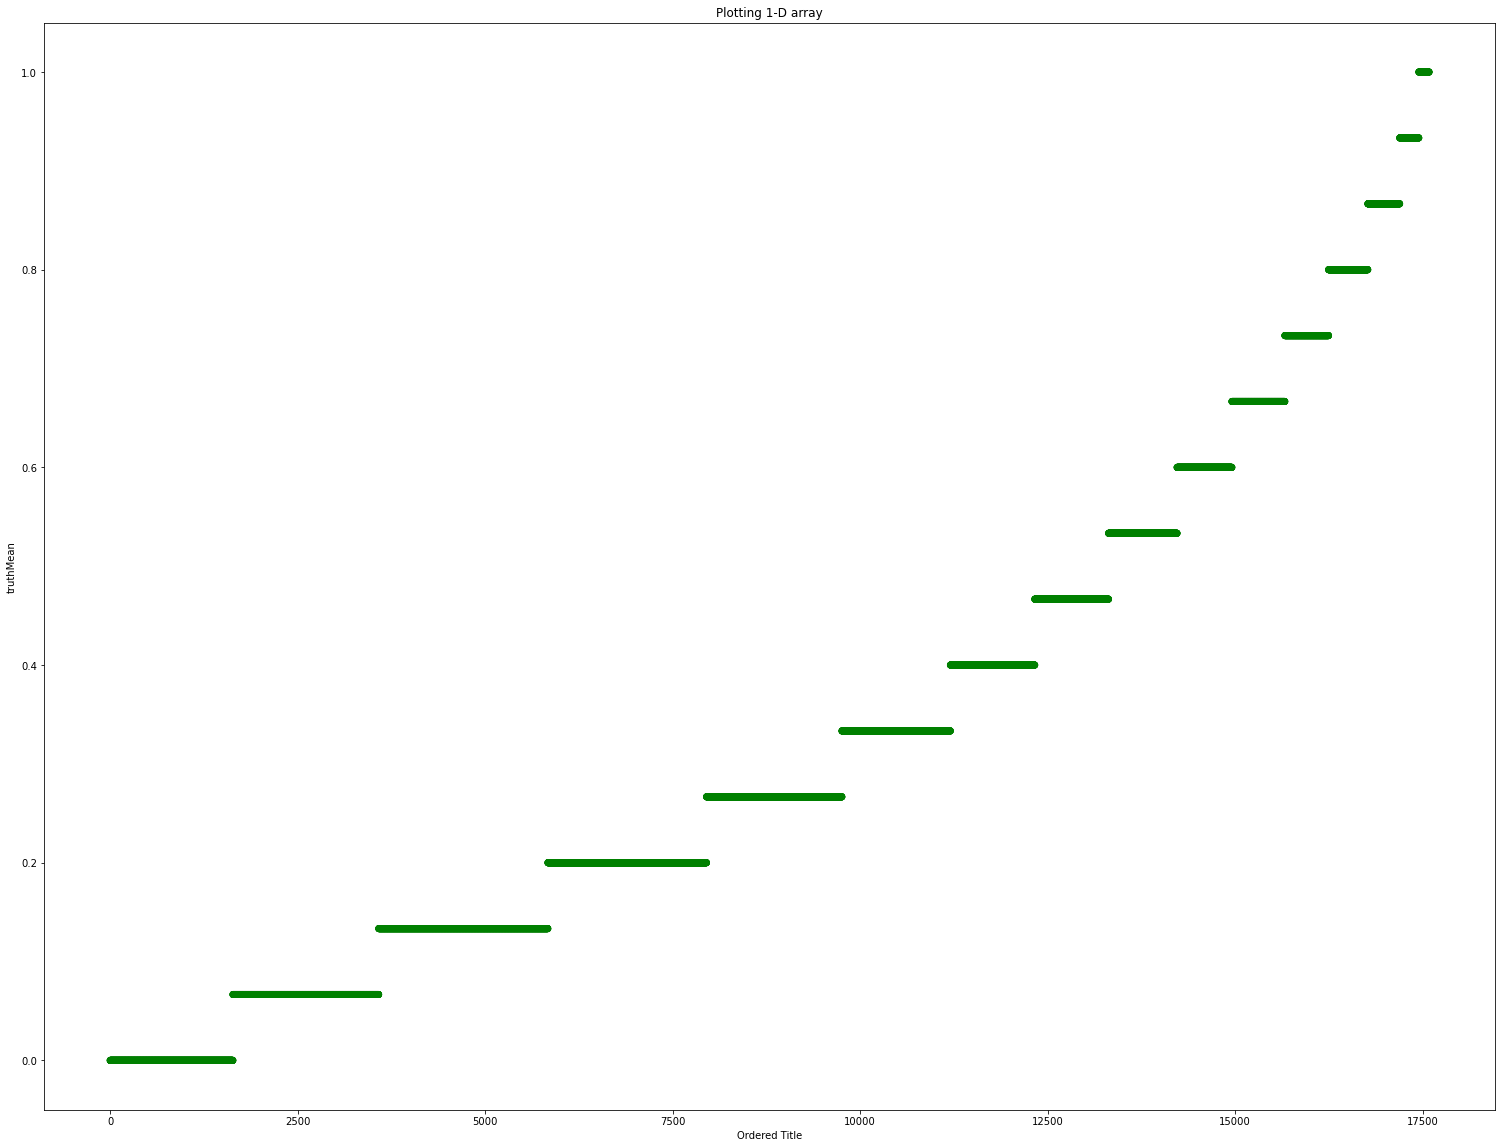

In [33]:
plt.figure(figsize=(26, 20))
plt.title("Plotting 1-D array")
plt.xlabel("Ordered Title")
plt.ylabel(LCfraction) #LCfraction
x = np.array(range(0, tct.shape[0]))
y = tct[LCfraction] # 
# color = [palette[val] for val in tct["labelC"]]
plt.scatter(x, y, c = color, marker = "o", label = "Array elements")

In [35]:
tct["labelC"].describe()

count    17584.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: labelC, dtype: float64

In [36]:
tct.corr()

,id,truthMean,labels,labelC
id,1.000000,-0.006307,-0.005054,NaN
truthMean,-0.006307,1.000000,0.781204,NaN
labels,-0.005054,0.781204,1.000000,NaN
labelC,NaN,NaN,NaN,NaN
